In [1]:
#Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import math
import scipy.optimize as optimize
import itertools
from scipy.stats import norm
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.stats import qmc
import scipy.special
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel
from sklearn.metrics import log_loss
from sklearn.linear_model import LinearRegression

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pickle
import gzip

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calc_cs1_polynomial(true_model_coefficients, x):
    """
    Calculates the value of y for case study 1
    
    Parameters
    ----------
    true_model_coefficients: ndarray, The array containing the true values of Theta1 and Theta2
    x: ndarray, The list of xs that will be used to generate y
    
    Returns
    --------
    y_poly: ndarray, The noiseless values of y given theta_true and x
    """
    
    y_poly =  true_model_coefficients[0]*x + true_model_coefficients[1]*x**2 +x**3
       
    return y_poly

## define function that includes nonlinear model
def model(theta,x):
    '''
    Toy model
    Arguments:
        theta: parameter vector
        x: independent variable vector
    Returns:
        y_model: dependent variable prediction
    '''
    y_model = theta[0]*x + theta[1]*x**2 + x**3
    return y_model

##New Cell

# Create a function to optimize, in this case, least squares fitting
def regression_func(theta, x, y):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        theta: parameter vector
        x: independent variable vector
        y: dependent variable vector (measurements)
    Returns:
        e: residual vector
    '''
    
    error = y - model(theta,x); #NOTE: Least squares will calculate sse based off this to minimize
    
    return error
#New Cell

#Create a function to define the SSE for any Theta vector on a heat map.
def sse_func(xx, yy, x, y):
    '''
    Function to define define sum of squared error function for heat map
    Arguments:
        xx: An N X D array of all Theta1 values
            
        yy: An D X N array of all Theta2 values
        theta: parameter vector
        x: independent variable vector (predicted x values including noise)
        y: dependent variable vector (predicted y values on Heat Map)
    Returns:
        sse: N x N sum of squared error matrix of all generated combination of xx and yy
    '''
    sse = np.zeros([len(xx),len(yy)])
    
    for i in range(len(xx)):
        for j in range(len(yy)):
            theta = np.array([xx[i][j],yy[i][j]])
            sse[i][j] = sum((y - model(theta,x))**2) 
    
    return sse


def lhs_sampling(num_points, bounds, seed):
    """
    Design LHS Samples

    Parameters
    ----------
    num_points: int, number of points in LHS, should be greater than # of dimensions
    bounds: ndarray, array containing upper and lower bounds of elements in LHS sample. Defaults of 0 and 1
    seed: int, seed of random generation

    Returns
    -------
    lhs_data: ndarray, array of LHS sampling points with length (num_points) 
    """
    #Define number of dimensions
    dimensions = bounds.shape[1]
    #Define sampler
    sampler = qmc.LatinHypercube(d=dimensions, seed = seed)
    lhs_data = sampler.random(n=num_points)

    #Generate LHS data given bounds
    lhs_data = qmc.scale(lhs_data, bounds[0], bounds[1]) #Using this because I like that bounds can be different shapes

    return lhs_data



theta_names = ['theta_1', 'theta_2']
bounds_x_l = [-2]
bounds_x_u = [2]
bounds_theta_l = [-2, -2]
bounds_theta_u = [ 2,  2]
theta_ref = np.array([1.0, -1.0])   
seed = 1
np.random.seed(seed)
noise_mean = 0
noise_std = 0.01

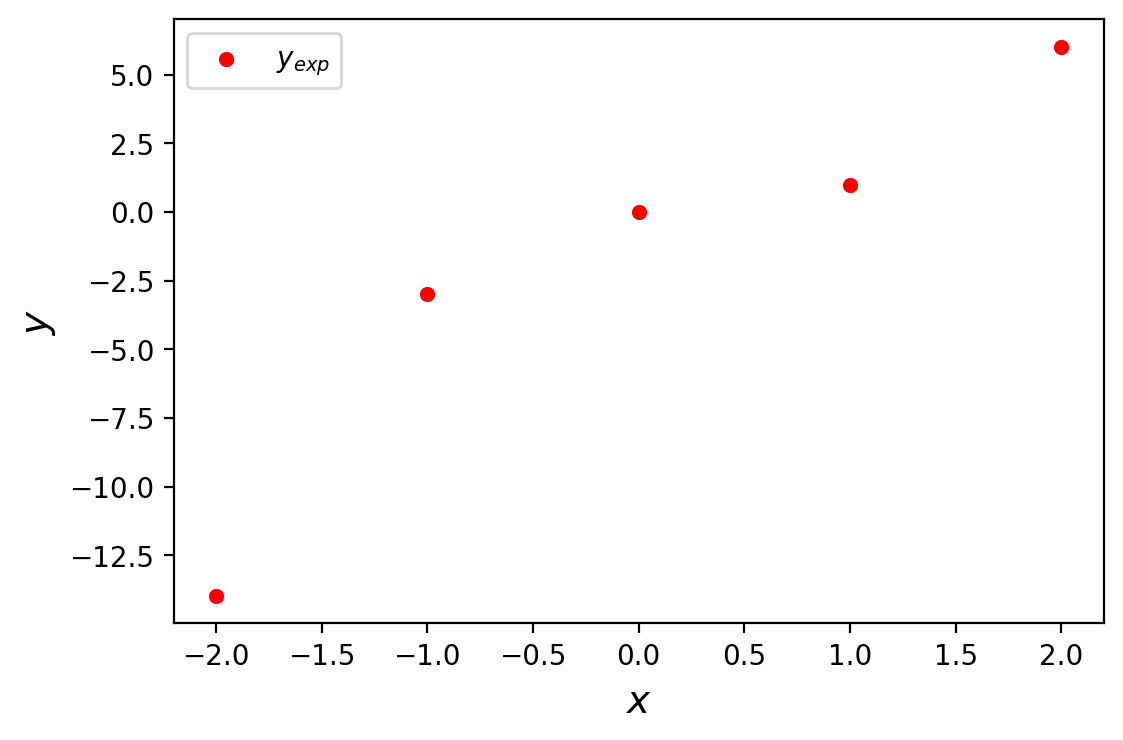

CPU times: user 280 ms, sys: 25.6 ms, total: 306 ms
Wall time: 304 ms


In [3]:
%%time
# Create synthetic data assuming the following values for theta
Theta_Guess = np.array([1,-1])

# Evaluate model and add noise based on assumed theta values
# This generates experimental data points
Xexp = np.linspace(-2,2,5)
Yexp = calc_cs1_polynomial(theta_ref, Xexp)
#Creates noise values with a certain stdev and mean from a normal distribution
noise = np.random.normal(size=len(Yexp), loc = noise_mean, scale = noise_std)
#Add noise to data
Yexp = Yexp + noise

# Evaluate model based on the assumed experimental values
X = np.linspace(np.min(Xexp),np.max(Xexp),50)
Y = Theta_Guess[0]*X + Theta_Guess[1]*X**2 + X**3

# Compare the experiments to the true model
# plt.plot(X,Y,'b-',linewidth=2,label=r"$y$")
plt.scatter(Xexp,Yexp, color = "r", s=20,label=r"$y_{exp}$")
# plt.title("Plotting True Model and Synthetic Data")
plt.xlabel(r"$x$",fontsize=14)
plt.ylabel(r'$y$',fontsize=14)
plt.legend()
plt.show()

##New Cell



In [16]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
anis = False
lenscl = None

#Set GP Model
noise_kern = WhiteKernel(noise_level=noise_std**2, noise_level_bounds= "fixed") #bounds = "fixed"
kernel = ConstantKernel(constant_value=1, constant_value_bounds = "fixed")*(Matern(length_scale_bounds=(1e-05, 1e5), 
         nu=2.5) + noise_kern)

#Set lenscl
if anis == True:
    lengthscale_val = np.ones(2)
else:
    lengthscale_val = 1
    
if lenscl is not None:
    lengthscale_val = lengthscale_val*lenscl
    kernel.k2.k1.length_scale_bounds = "fixed"

#Set initial model lengthscale
kernel.k2.k1.length_scale = lengthscale_val

gp_model = GaussianProcessRegressor(kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=5, 
                                            random_state = seed, optimizer = "fmin_l_bfgs_b")

y_train = calc_cs1_polynomial(theta_ref, Xexp)
fit_gp_model = gp_model.fit(Xexp.reshape(-1,1), Yexp)
#Pull out kernel parameters after GP training
opt_kern_params = fit_gp_model.kernel_
outputscl_final = opt_kern_params.k1.constant_value
lenscl_final = opt_kern_params.k2.k1.length_scale
noise_final = opt_kern_params.k2.k2.noise_level

print(outputscl_final, lenscl_final, noise_final)
Y_gp, stdev_gp = fit_gp_model.predict(X.reshape(-1,1), return_std=True)
__, cov_2 = fit_gp_model.predict(X.reshape(-1,1), return_cov = True)

1 0.5839422656799422 0.0001


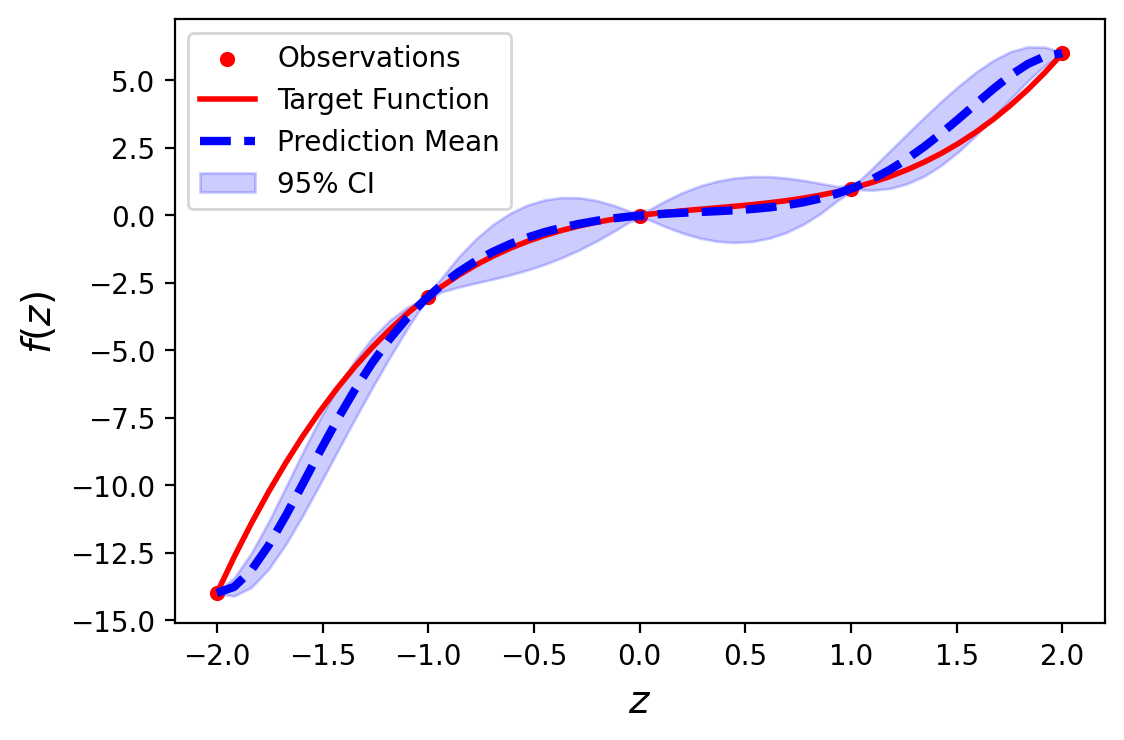

In [17]:
# Compare the experiments to the true model
# plt.plot(X,Y,'b-',linewidth=2,label=r"$y$")
plt.scatter(Xexp,Yexp, color = "r", s=20,label="Observations")#r"$y_{exp}$")
plt.plot(X,Y,'r-',linewidth=2,label="Target Function")#r"$y_{true}$")
plt.plot(X,Y_gp,'b',linestyle = "--", linewidth = 3, label="Prediction Mean")#r"$y_{gp}$")
plt.fill_between(X, Y_gp-1.96*stdev_gp, Y_gp+1.96*stdev_gp, alpha=0.2, color = "b", label = "95% CI")
# plt.title(r"all trained")
plt.xlabel(r"$z$",fontsize=14)
plt.ylabel(r'$f(z)$',fontsize=14)
plt.legend()
plt.show()

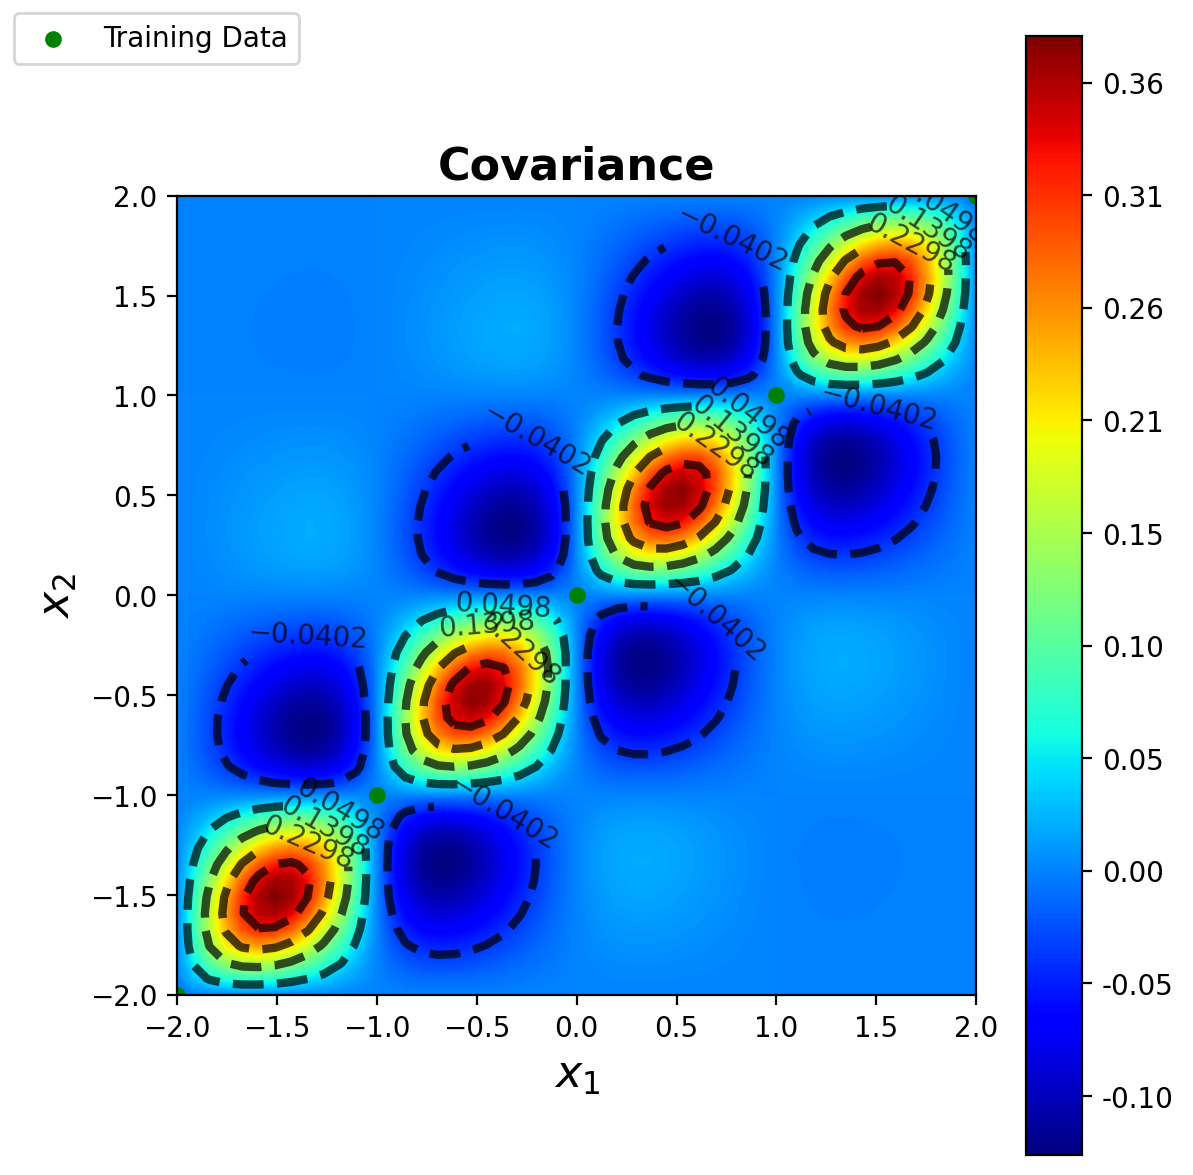

In [6]:
# Plot covariance
#Plot
XX_mesh = np.array(np.meshgrid(X,X))
X1, X2 = XX_mesh
z = cov_2
tot_lev = 150
#Set plot details for mean predictions
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6,6))
ax = axes
title = "Covariance"
# title = ["Mean", "StDev"]
     
#Create a colormap and colorbar for each subplot
cs_fig = ax.contourf(X1, X2,z, levels = 900, cmap = "jet")
if np.amax(z) < 1e-1 or np.amax(z) > 1000:
    cbar = plt.colorbar(cs_fig, ax = ax, format='%.2e')
else:
    cbar = plt.colorbar(cs_fig, ax = ax, format = '%2.2f')

#Create a line contour for each colormap
cs2_fig = ax.contour(cs_fig, levels=cs_fig.levels[::tot_lev], colors='k', alpha=0.7, linestyles='dashed', linewidths=3)
ax.clabel(cs2_fig,  levels=cs_fig.levels[::tot_lev], fontsize=10, inline=1)
ax.scatter(Xexp,Xexp, color="green",s=25, label = "Training Data", marker = "o")  



#Get legend information
handles, labels = ax.get_legend_handles_labels()

#Plots axes such that they are scaled the same way (eg. circles look like circles) and name axes
ax.axis('scaled')  
ax.set_xlabel('$x_1$',weight='bold',fontsize=16)
ax.set_ylabel('$x_2$',weight='bold',fontsize=16)

#Plot title and set axis scale
ax.set_title(title, weight='bold',fontsize=16)
ax.set_xlim(left = np.amin(X1), right = np.amax(X1))
ax.set_ylim(bottom = np.amin(X2), top = np.amax(X2))      

#Plots legend and title
plt.tight_layout()
fig.legend(handles, labels, loc="upper left")  #bbox_to_anchor=(-0.01, 0.9), borderaxespad=0
plt.show()

In [7]:
bounds = ([-np.inf, -np.inf], [np.inf, np.inf])
theta0 = np.random.rand(2) * (2+2) -2
Solution = optimize.least_squares(regression_func, theta0,bounds=bounds, method='trf',args=(Xexp, Yexp),verbose=2)

theta = Solution.x
print("theta = ",theta)
X_pred = X
Y_pred = model(theta, X_pred)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.0106e+01                                    5.91e+01    
       1              2         2.1725e+01      3.84e+01       8.08e-01       3.30e+01    
       2              3         1.3933e-04      2.17e+01       1.45e+00       4.11e-15    
`gtol` termination condition is satisfied.
Function evaluations 3, initial cost 6.0106e+01, final cost 1.3933e-04, first-order optimality 4.11e-15.
theta =  [ 0.99802091 -0.99756639]


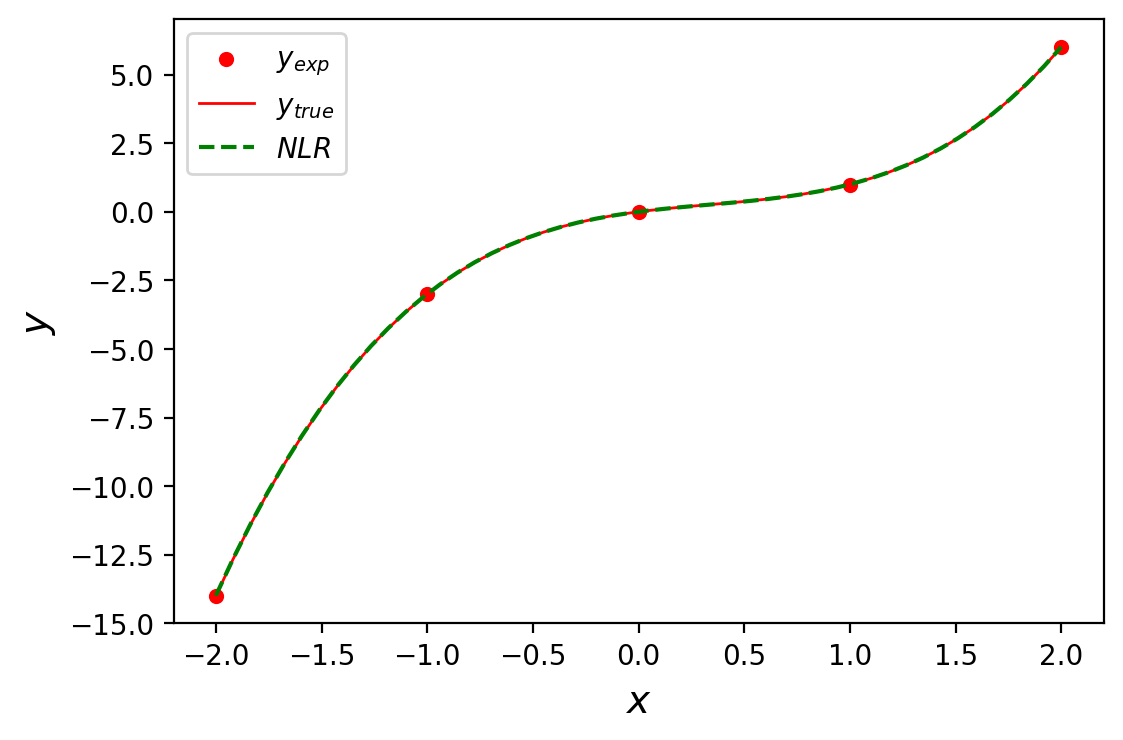

In [8]:
# plt.plot(X,Y,'b-',linewidth=2,label=r"$y$")
plt.scatter(Xexp,Yexp, color = "r", s=20,label=r"$y_{exp}$")
plt.plot(X,Y,'r-',linewidth=1,label=r"$y_{true}$")
plt.plot(X_pred, Y_pred, linestyle = "--", color = "g", label=r"$NLR$")
# plt.plot(X,Y_gp,'b',linestyle = "--",label=r"$y_{gp}$", linewidth = 3)
# plt.fill_between(X, Y_gp-2*stdev_gp, Y_gp+2*stdev_gp, alpha=0.2, color = "b", label = "95% CI")
# plt.title(r"all trained")
plt.xlabel(r"$x$",fontsize=14)
plt.ylabel(r'$y$',fontsize=14)
plt.legend()
plt.show()

In [9]:
def plot_x_vs_y_given_theta2(data, exp_data, train_data, test_data, xbins, ybins, title, x_label, y_label, title_fontsize = 24, other_fontsize = 20, save_path = None):
    """
    Plots x data vs y data for any given parameter set theta
    
    Parameters
    ----------
    data: Instance of Data,
    
    """
    subplots_needed = data.get_dim_x_vals()
    fig, ax, num_subplots = create_subplots(subplots_needed)
    
    #Print the title and labels as appropriate
    set_plot_titles(fig, title, x_label, y_label, title_fontsize, other_fontsize)
        
    #Loop over different hyperparameters (number of subplots)
    for i in range(num_subplots):
        #If you still have data to plot
        if i < data.get_dim_x_vals():
            #The index of the data is i, and one data type is in the last row of the data
            X_space = data.x_vals[:,i]
            if not len(train_data.y_vals) == len(train_data.x_vals):            
                ax[i].plot(X_space, np.zeros(len(X_space)), label = r"$y_{true}$", color = "red")
                y_NLR = regression_func(theta, exp_data.x_vals[:,i], exp_data.y_vals)
                ax[i].plot(exp_data.x_vals[:,i], y_NLR, linestyle = "--", color = "g", label=r"$NLR$")    
            else:
                if exp_data is not None:
                    ax[i].scatter(exp_data.x_vals[:,i], exp_data.y_vals, color = "red", marker = "o", label = r"$y_{exp}$")
                ax[i].plot(X_space, data.y_vals, label = r"$y_{true}$", color = "red")            
                ax[i].plot(X_space, model(theta, X_space), linestyle = "--", color = "g", label=r"$NLR$")   
                
            ax[i].plot(X_space, data.gp_mean, lw=2, label=r"$y_{gp}$", color = "blue")
                
#             if train_data is not None:
#                 ax[i].scatter(train_data.x_vals[:,i], train_data.y_vals, color = "green",  s=150, marker = "x", label = "Training")
#             if test_data is not None:
#                 ax[i].scatter(test_data.x_vals[:,i], test_data.y_vals, color = "red", s=100, marker = "x", label = "Testing")
            
            ax[i].fill_between(
                X_space,
                data.gp_mean - 1.96 * np.sqrt(data.gp_var),
                data.gp_mean + 1.96 * np.sqrt(data.gp_var),
                alpha=0.3, label = "95% CI" )
            subplot_details(ax[i], X_space, None, None, None, None , xbins, ybins, other_fontsize)
        #Set axes off if it's an extra
        else:
            ax[i].set_axis_off()
            
        #Fetch handles and labels on last iteration
        if i == num_subplots-1:
            handles, labels = ax[i].get_legend_handles_labels()
            
    #Plots legend and title
    plt.tight_layout()
    fig.legend(handles, labels, loc= "upper left", fontsize = other_fontsize, bbox_to_anchor=(1.0, 0.95), borderaxespad=0)
    
    #save or show figure
    if save_path is None:
        plt.show()
        plt.close()
    else:
        save_fig(save_path, ext='png', close=True, verbose=False)  
    
    return

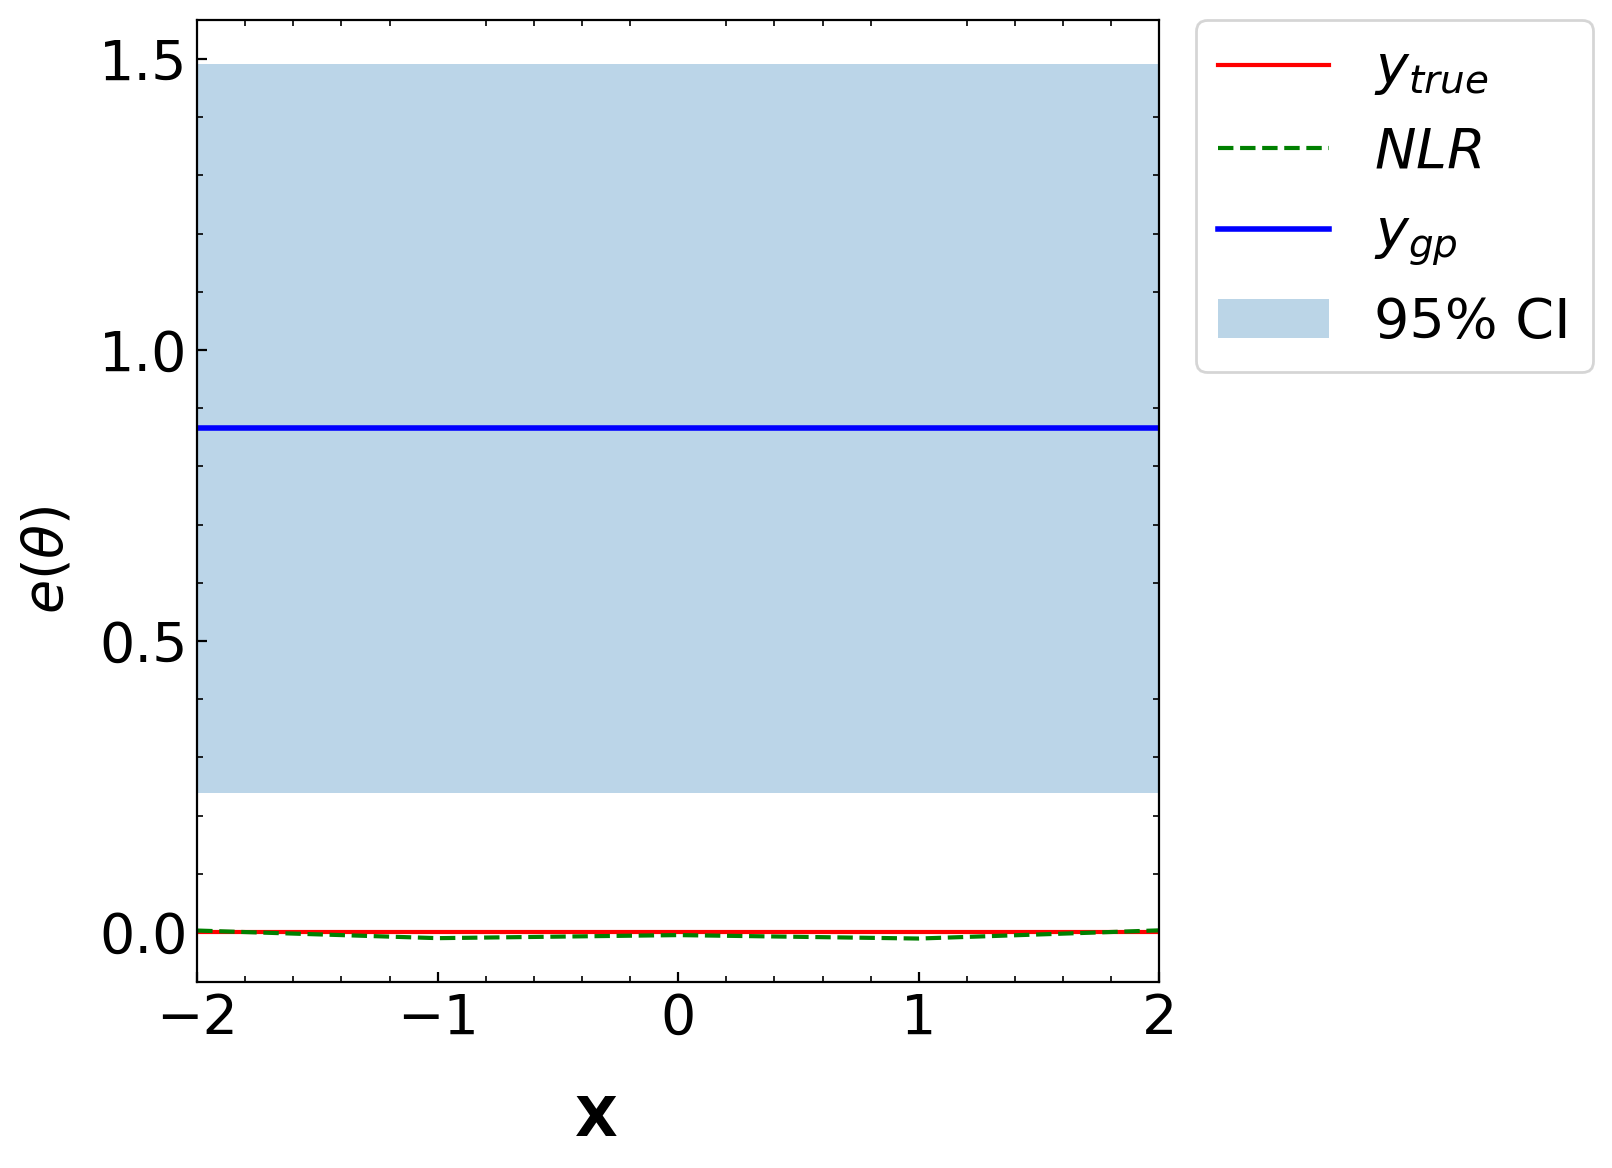

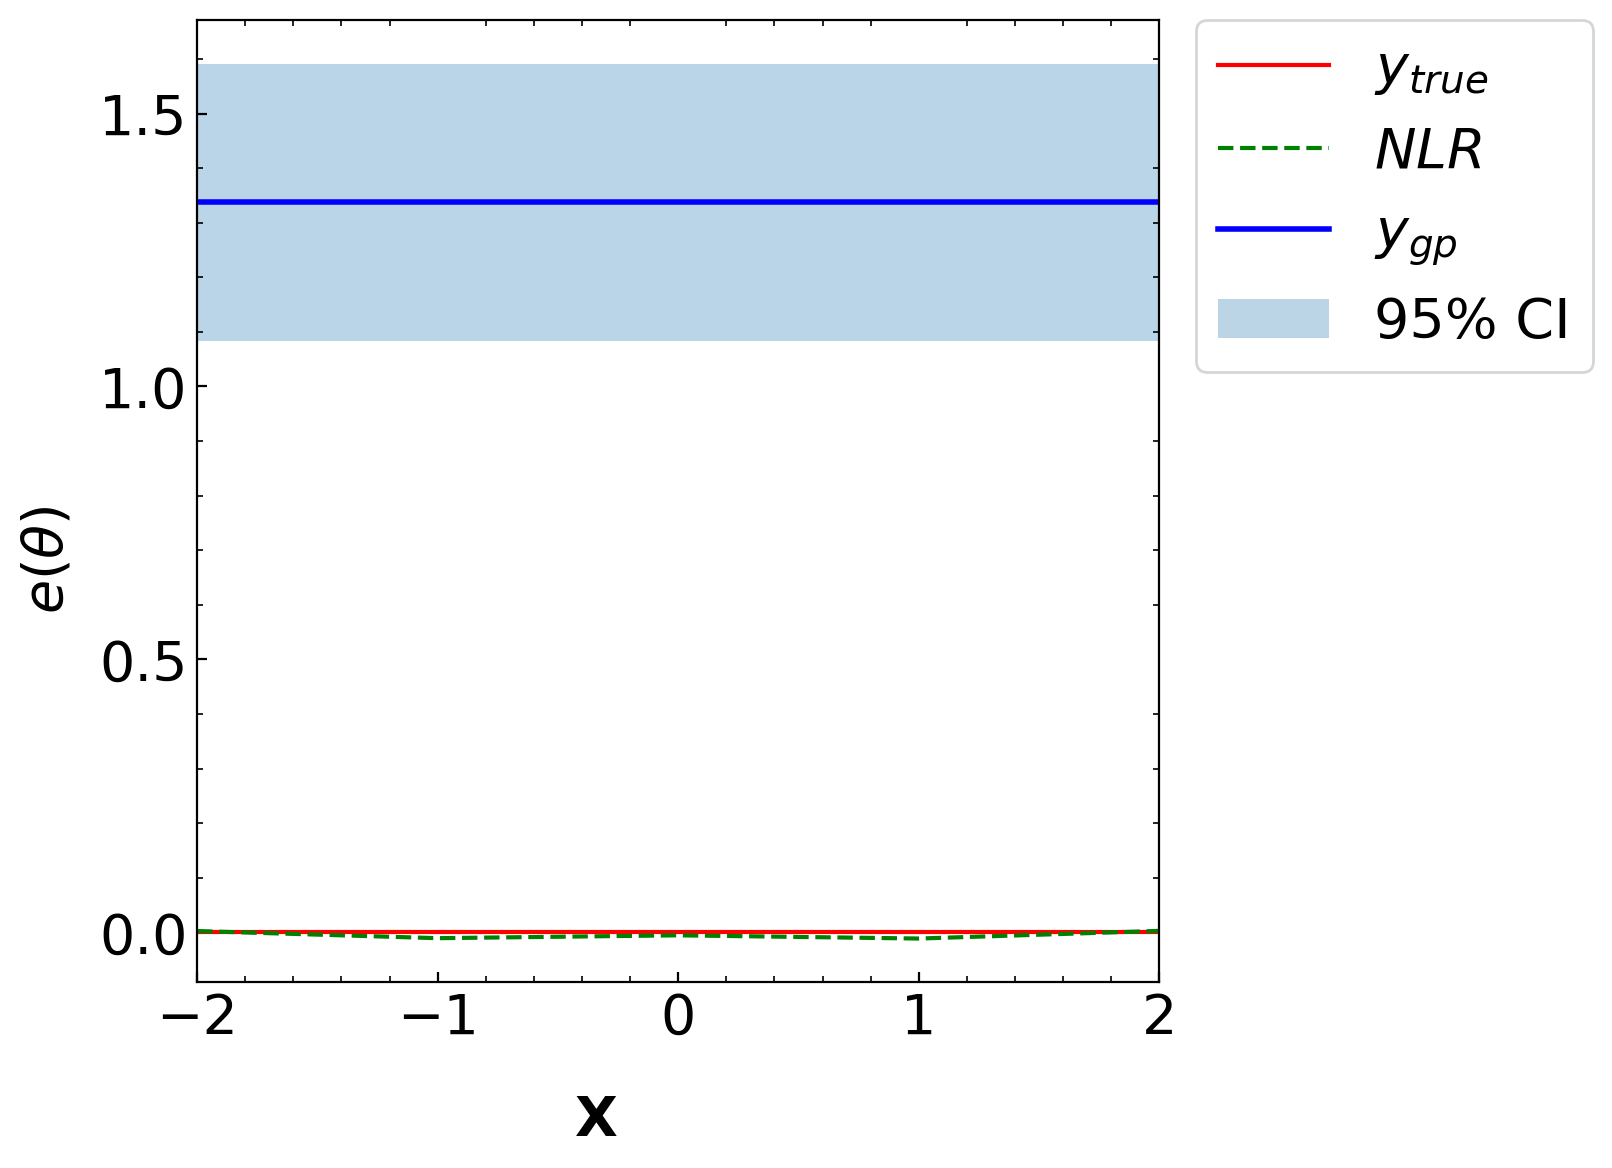

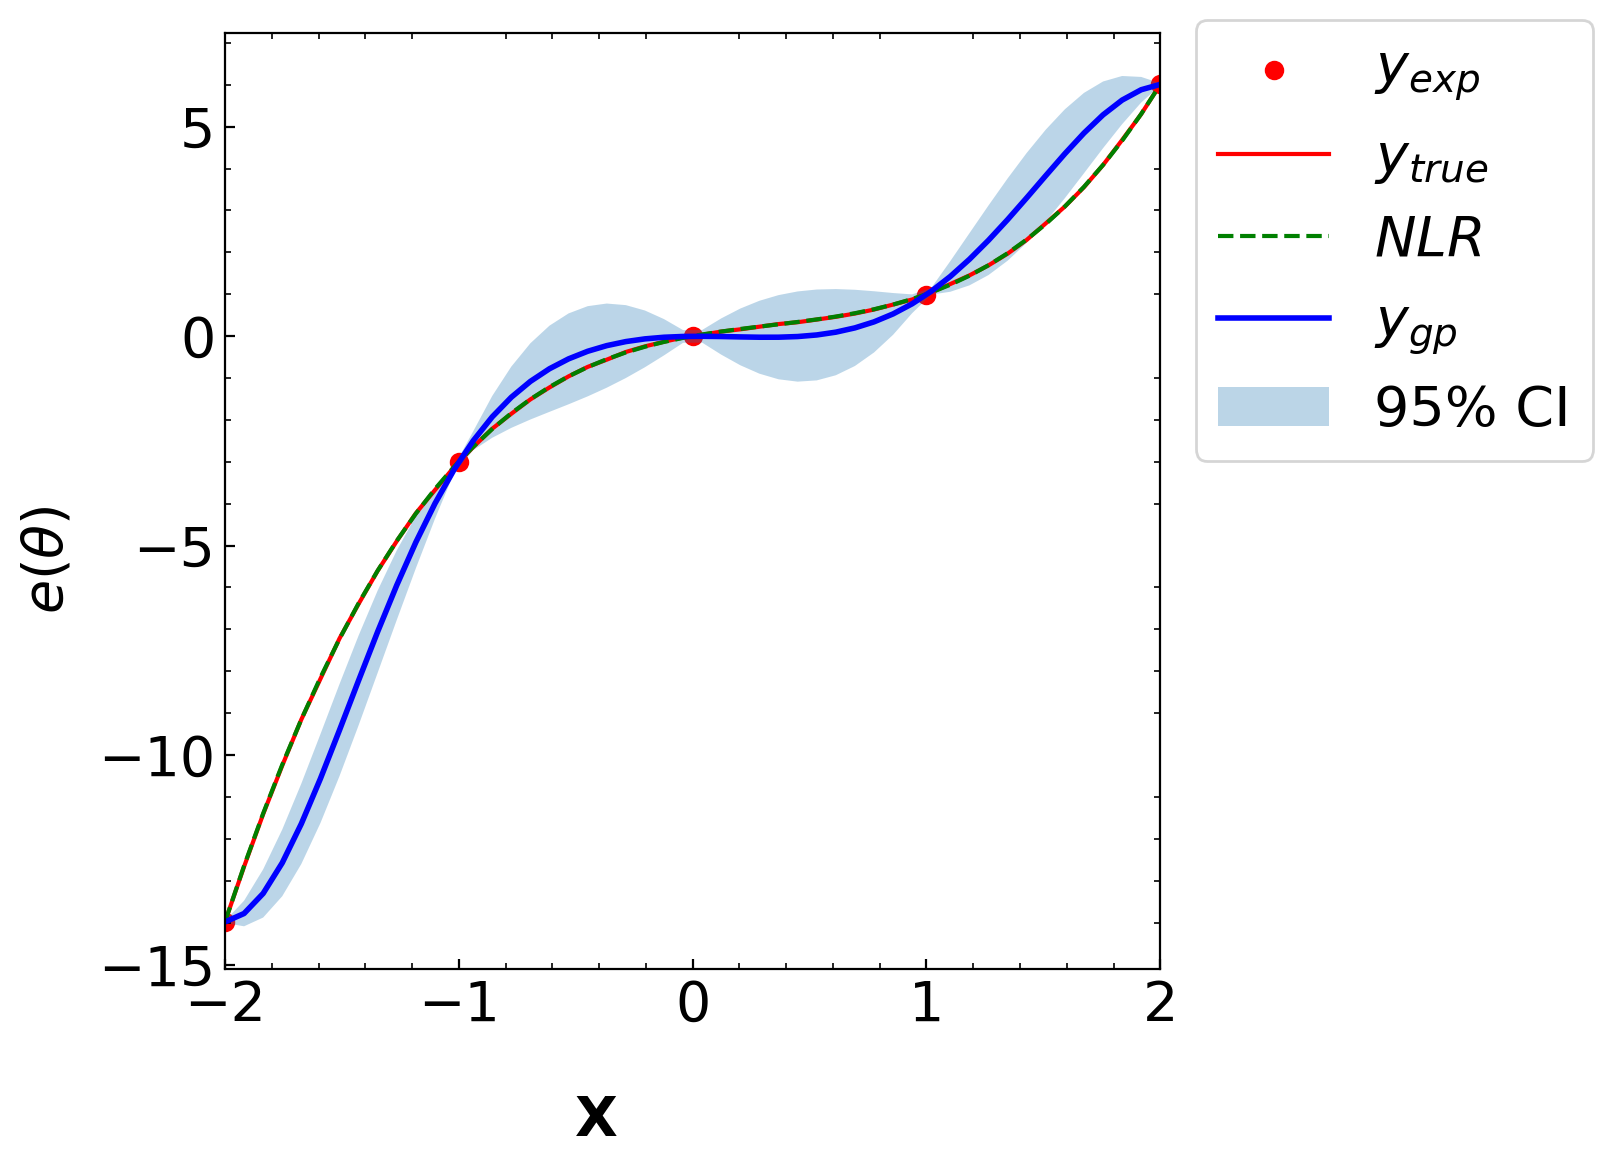

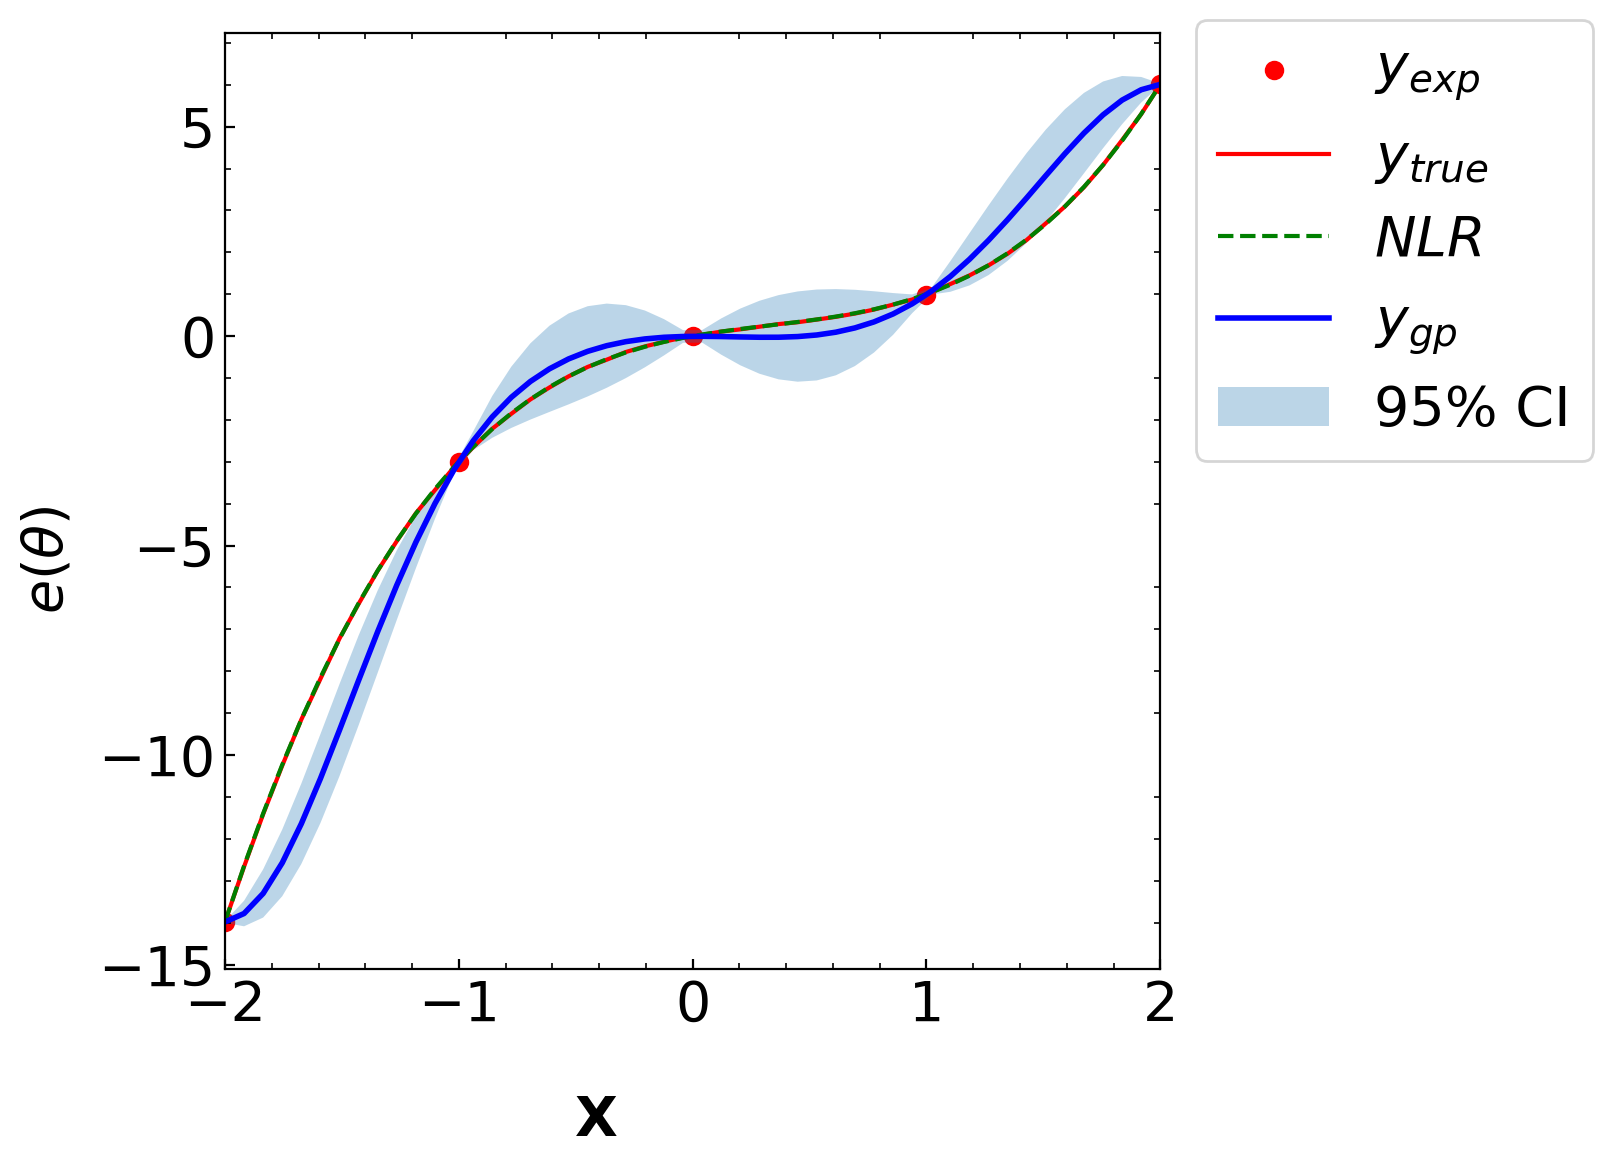

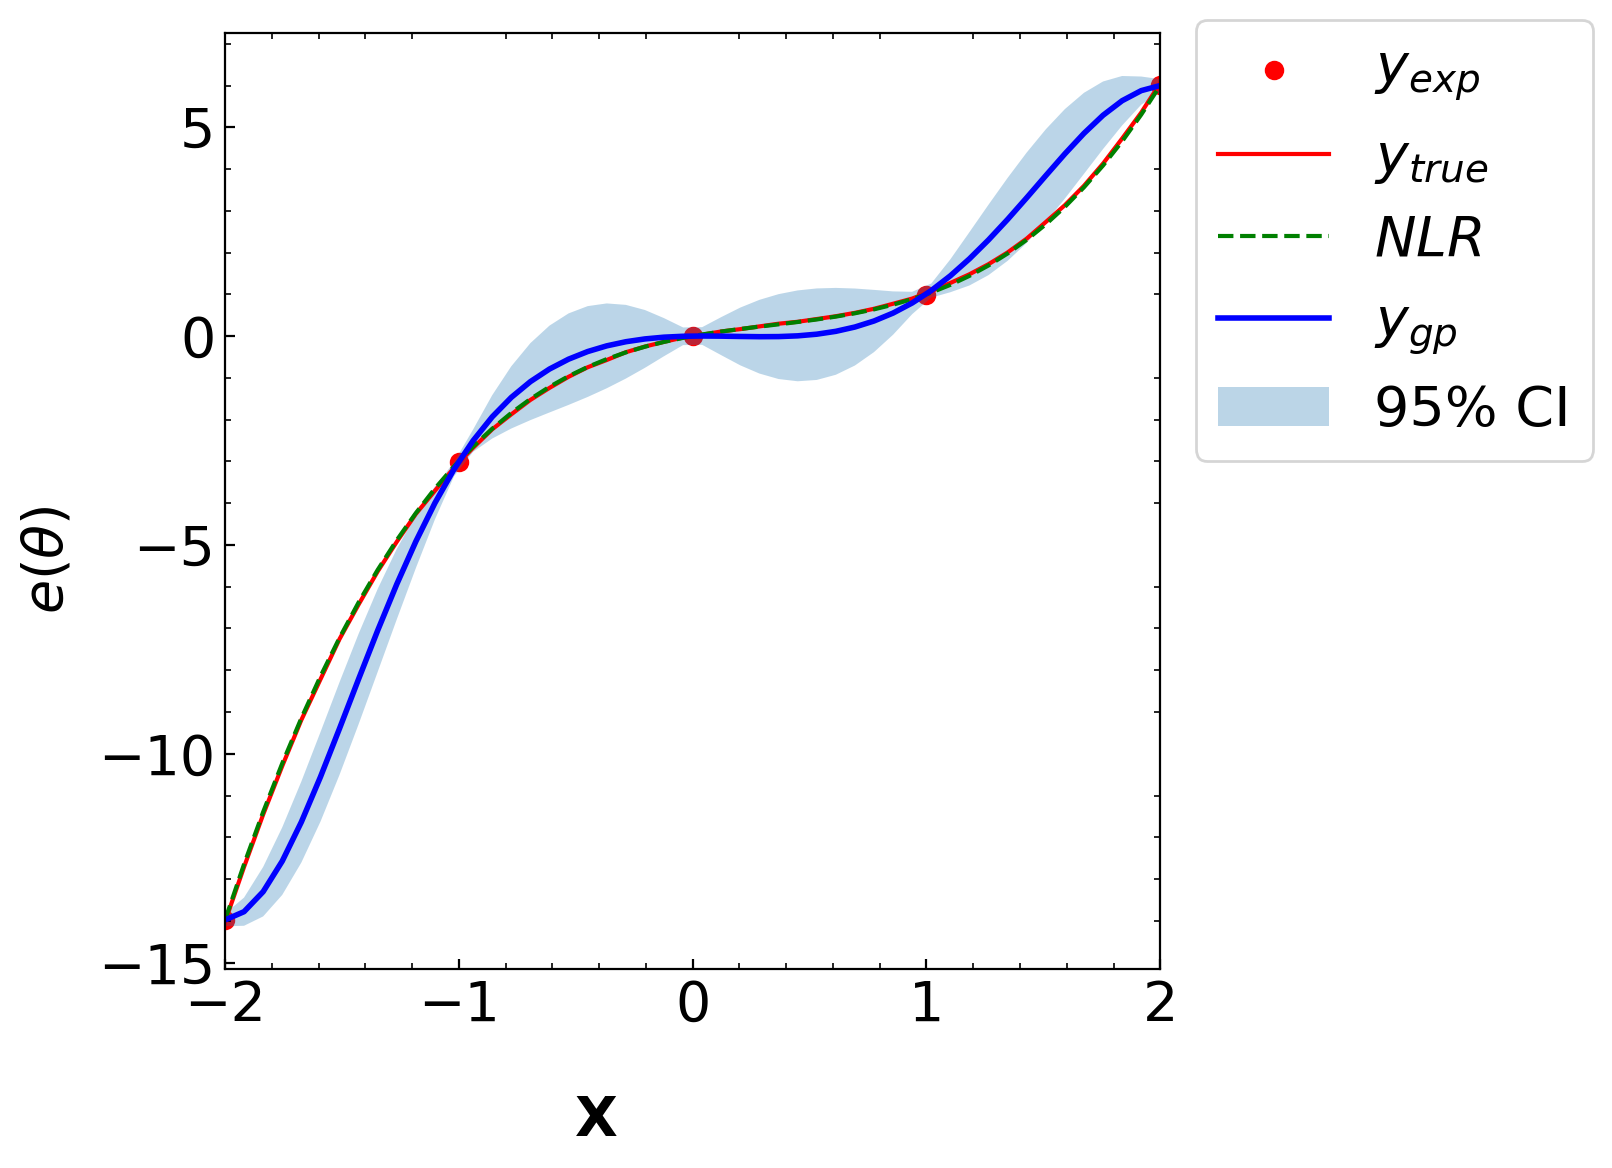

In [10]:
#Plot xy data
path_list = ["2b0d1ee15911cd245f17a7d10a7abf3e",
             "b0e257d6e76025909e364903b3b792ee",
             "d0c8b17229671998f3ffdab06c79e1f9",
             "fdc2673ac83f3d0cf5b3b969a3e80825",
             "9042085b58a00b76d6c2ae0a20cfe9f3"]

df_best_path = "workspace/" + path_list[0] + "/ep_study_best_all.csv"
df_best = pd.read_csv(df_best_path, header = 0, index_col = 0)
run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
bo_iter_list = list(map(int, df_best["BO Iter"].to_numpy() + 1))

for i in range(len(path_list)):
    file_path = "workspace/" + path_list[i] + "/BO_Results.gz"
    
    run_num = run_num_list[i]
    bo_iter = bo_iter_list[i]
    x_lin_pts = 50

    title_fontsize = 24
    other_fontsize = 20
    save_path = None

    xbins = 5
    ybins = 5
    title = None
    x_label = r"X"
    y_label = r"$e(\theta)$"

    theta_opt_data, exp_data, train_data, test_data = analyze_xy_plot(file_path, run_num, bo_iter, x_lin_pts)
    plot_x_vs_y_given_theta2(theta_opt_data, exp_data, train_data, None, xbins, ybins, title, x_label, y_label, 
                            title_fontsize, other_fontsize, save_path)

In [ ]:
def acquisition_EI(mean, variance, output, xi=0.01):
    best = np.max(output)
    mu, std = mean, variance
    mu = mu.reshape(-1, 1)
    std = std.reshape(-1, 1)
    imp = best -mu - xi
    Z = imp / std
    ei = imp * norm.cdf(Z) + std * norm.pdf(Z)
    ei[std == 0.0] = 0.0
    return ei.reshape(-1)

In [ ]:
import numpy as np
from scipy.stats import norm

def acquisition_EI(mean, variance, output, xi=0.01):
    best = np.max(output)
    mu, std = mean, variance
    mu = mu.reshape(-1, 1)
    std = std.reshape(-1, 1)
    imp = best -mu - xi
    Z = imp / std
    ei = imp * norm.cdf(Z) + std * norm.pdf(Z)
    ei[std == 0.0] = 0.0
    return ei.reshape(-1)

from matplotlib import pyplot as plt
import numpy as np

save_figure = False
#Original z 0.0015 * x**5 - 0.055 * x**4 + 0.65 * x**3 - 2.8 * x**2 + 3.0 * x + 6.3
# 目标函数                                                                                                                                                                  
objective = np.vectorize(lambda x, sigma_n=0.01: 1*x -1*x**2 +x**3  + np.random.normal(0, sigma_n))

# 采样函数 - GP-UCB                                                                                                                                                         
GPUCB = np.vectorize(lambda mu, sigma, t, ld, delta=0.1: mu + (1 * 2 * np.log(ld * t**2 * np.pi**2 / (6 * delta)))**0.5 * sigma)

# 超参数                                                                                                                                                                    
mean, l, sigma_f, sigma_n = 5, 1, 1, 0.01

# 迭代次数                                                                                                                                                                  
max_iter = 3

# SE协方差函数                                                                                                                                                              
kernel = lambda r_2, l: np.exp(-r_2 / (2 * l**2))

# 初始训练样本，以一维输入为例                                                                                                                                              
X = np.linspace(-2,2,5)
X = X.reshape(X.size, 1)
Y = objective(X).flatten()

plt.figure(figsize=(15,15))

j = 0
for i in range(max_iter):
  
    Xs = np.linspace(-2,2,100)
    Xs = Xs.reshape(Xs.size, 1)

    n, d = X.shape
    t = np.repeat(X.reshape(n, 1, d), n, axis=1) - X
    r_2 = np.sum(t**2, axis=2)
    Kf = sigma_f**2 * kernel(r_2, l)
    Ky = Kf + sigma_n**2 * np.identity(n)
    Ky_inv = np.linalg.inv(Ky)

    m = Xs.shape[0]
    t = np.repeat(Xs.reshape(m, 1, d), n, axis=1) - X
    r_2 = np.sum(t**2, axis=2).T
    kf = sigma_f**2 * kernel(r_2, l)

    mu = mean + kf.T @ Ky_inv @ (Y - mean)
    sigma = np.sqrt(sigma_f**2 - np.sum(kf.T @ Ky_inv * kf.T, axis=1))
    print(sigma)

    # y_acf = GPUCB(mu, sigma, i + 1, n)
    y_acf = acquisition_EI(mu, sigma, Y)

    sample_x = np.around(Xs[np.argmax(y_acf)])
    print(sample_x)


    x_test = Xs.flatten()
    y_obj = objective(x_test).flatten()

    j = j+1
    ax = plt.figure(figsize=(6, 4), dpi=200)
#     ax = plt.subplot(max_iter, 2, j)
    # ax.set_title('Iteration %d' % (i + 1), fontsize=20)
#     plt.ylim(0, 14)
    
    if i == 0:
      plt.plot(x_test, mu, c='tab:blue', lw=2, label='Predicted Mean')
      plt.fill_between(x_test, mu + 1.96*sigma, mu - 1.96*sigma, alpha=0.2, color='tab:blue', lw=0, label='95% Prediction Interval')
      plt.plot(x_test, y_obj, c='red', ls='--', lw=2, label = 'Target Function')
      plt.scatter(X, Y, c='red', marker='o', s=80, label = 'Observations')
      plt.xlabel(r'$\mathit{z}$', fontsize=20)
    
    if i != 0:
      plt.plot(x_test, mu, c='tab:blue', lw=2, label='Predicted Mean')
      plt.fill_between(x_test, mu + 1.96*sigma, mu - 1.96*sigma, alpha=0.2, color='tab:blue', lw=0, label='95% Prediction Interval')
      plt.plot(x_test, y_obj, c='red', ls='--', lw=2, label = 'Target Function')

      text = 'New Observation ' + r'($\bar{\mathit{z}}_' + str(i) + r'$)'
      plt.scatter(X[1:], Y[1:], c='red', marker='o', s=80, label = 'Observations')
      plt.scatter(X[0], Y[0], marker='*', c='navy',s=150, label=text)
      plt.xlabel(r'$\mathit{z}$', fontsize=20)

#     plt.ylabel('Iteration  ' + str(i+1), fontsize=20)
    plt.ylabel(r'$f(\mathit{z})$', fontsize=20)
    
    if i == max_iter-1:
      plt.xlabel(r'$\mathit{z}$', fontsize=20)
#     if i == 0:
#       plt.title('$f(x)$', fontsize=20)
    plt.xticks(np.arange(-2, 2.1, 1.0), fontsize = 15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=12, loc='upper left')
#     plt.grid()
    plt.tight_layout()
    if save_figure == True:
        plt.savefig('BO_demo_min_Obj_z'+str(i+1))
        plt.close()
    plt.show()
    
    
    
    j = j + 1
#     plt.subplot(max_iter, 2, j)
    plt.figure(figsize=(6, 4), dpi=200)
    # plt.ylim(-0.001, 0.10)
    plt.ticklabel_format(axis='y', style='sci', scilimits=[1e-2, 1e2])
    plt.plot(x_test, y_acf, c='darkgreen', lw=2, label='Acquisition Function')
#     if i == 0:
#       plt.title('Expected Improvement', fontsize=20)
    plt.ylabel(r'$EI(\mathit{z})$', fontsize=20)
#     if i == 3:
    plt.xlabel(r'$\mathit{z}$', fontsize=20)

    text = 'EI Maximum ' + r'($\bar{\mathit{z}}_' + str(i+1) + r'$)'
    print(text)

    plt.scatter(x_test[np.argmax(y_acf)], y_acf[np.argmax(y_acf)], marker='*', c='navy',s=150,  label=text)
    plt.legend(fontsize=15, loc='lower center')
    # plt.title('Acquisition Function')
    plt.xticks(np.arange(-2, 2.1, 1.0), fontsize = 15)
    plt.yticks(fontsize=15)
#     plt.grid()

    X = np.insert(X, 0, sample_x, axis=0)
    Y = np.insert(Y, 0, objective(sample_x))
    
    print(x_test[np.argmax(y_acf)])
    plt.tight_layout()
    if save_figure == True:
        plt.savefig('BO_demo_min_EI_z'+str(i+1))
        plt.close()
#     plt.show()
    # plt.suptitle('Bayesian Optimization Example \n $f(x) = 0.0015  x^5 - 0.055x^4 + 0.65 x^3 - 2.8 x^2 + 3.0 x + 6.3$', fontsize=25)
# if save_figure == True:
#     plt.savefig('BO_demo_1')
# plt.show()
